In [13]:
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import os
import toolsets.file_io as io
from feature_normalization.rt_normalization import find_istd
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from feature_finding.feature_finding_alphapept import find_feature

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
peak_list_dir = '/Users/fanzhou.kong/Dropbox (Brightseed)/Mac/Documents/GitHub/data_garage/brighseed/peak_list/20230206_PHV_H2L_1870AX_M5P2_M7P1/pos'
istd_info = pd.read_csv(os.path.join('/Users/fanzhou.kong/Dropbox (Brightseed)/Mac/Documents/GitHub/data_garage/brighseed/istd_info', '20230206_PHV_H2L_1870AX_M5P2_M7P1.csv'))
mode = 'P'

In [3]:
seed_filename = 'QC_Pool1_P.txt'
seed_file = io.readin_MSDIAL(os.path.join(peak_list_dir, seed_filename))
test_file = io.readin_MSDIAL(os.path.join(peak_list_dir, '1870_AX_M5P2_M7P1_M7_X48_P.txt'))

In [4]:
seed_rt, seed_intensity = find_istd(istd_info, seed_file)
# test_rt, test_intensity = find_istd(istd_info, test_file)

In [5]:
# # raw_rt = []
# normalized_row = []
# raw_row = []
# # normalized_files = []
# # error_files = []
# for root, dirs, files in os.walk(peak_list_dir):
#     for file in tqdm(files):
#         # print(file)
#
#         if file.endswith('.txt'):
#             if file.split('.')[0][-1]==mode and file != seed_filename:
#                 test_file = io.readin_MSDIAL(os.path.join(peak_list_dir, file))
#                 raw_rt, raw_intensity = find_istd(istd_info, test_file)
#                 if len(raw_rt) == len(istd_info):
#                     #         check if all istds can be found
#                     rt_offset =  [seed - raw for (seed, raw) in zip(seed_rt, raw_rt)]
#                     # raw_row.extend()
#                     model_temp = RandomForestRegressor()
#                     model_temp.fit(np.array(raw_rt).reshape(-1,1), rt_offset)
#                     offset_pred = model_temp.predict(np.array(test_file['RT (min)']).reshape(-1,1))
#                     test_file.insert(4, 'RT_normalized', offset_pred+test_file['RT (min)'])
                    # break
                    # normalized_rt = [off+raw for (off, raw) in zip(offset_pred, raw_rt)]
                    # normalized_row_temp.extend(normalized_rt)
                    # raw_row_temp.extend(raw_rt)
                    # raw_row.append(raw_row_temp)
                    # normalized_row.append(normalized_row_temp)
                    # break
            # else:
            #     print('this file has a problem: ', file)

# col_names = ['ISTD']
# for istd in istd_info['compound_name']:
#     col_names.append(istd)
# raw_rt_df = pd.DataFrame(raw_row, columns=col_names)
# normalized_rt_df = pd.DataFrame(normalized_row, columns=col_names)

100%|██████████| 44/44 [00:06<00:00,  6.35it/s]


In [7]:
# raw_rt = []
normalized_row = []
raw_row = []
intensity_row = []
good_filenames = []
# error_files = []
for root, dirs, files in os.walk(peak_list_dir):
    for file in tqdm(files):
        # print(file)

        if file.endswith('.txt'):
            if file.split('.')[0][-1]==mode and file != seed_filename:
                test_file = io.readin_MSDIAL(os.path.join(peak_list_dir, file))
                raw_rt, raw_intensity = find_istd(istd_info, test_file)
                if len(raw_rt) == len(istd_info):
                    good_filenames.append(file.split('.')[0])
                    normalized_row_temp = [file.split('.')[0]]
                    raw_row_temp = [file.split('.')[0]]
            #         check if all istds can be found
                    rt_offset =  [seed - raw for (seed, raw) in zip(seed_rt, raw_rt)]
                    model_temp = RandomForestRegressor()
                    model_temp.fit(np.array(raw_rt).reshape(-1,1), rt_offset)
                    offset_pred = model_temp.predict(np.array(raw_rt).reshape(-1,1))
                    normalized_rt = [off+raw for (off, raw) in zip(offset_pred, raw_rt)]
                    normalized_row_temp.extend(normalized_rt)
                    raw_row_temp.extend(raw_rt)
                    raw_row.append(raw_row_temp)
                    normalized_row.append(normalized_row_temp)
                    intensity_row.append(raw_intensity)
                    # break
            # else:
            #     print('this file has a problem: ', file)

col_names = ['ISTD']
for istd in istd_info['compound_name']:
    col_names.append(istd)
raw_rt_df = pd.DataFrame(raw_row, columns=col_names)
normalized_rt_df = pd.DataFrame(normalized_row, columns=col_names)

100%|██████████| 44/44 [00:05<00:00,  8.07it/s]


In [8]:
raw_intensity_df = pd.DataFrame(intensity_row, columns=istd_info['compound_name'])

In [9]:
raw_intensity_df.rename(columns={'compound_name':'mix'}, inplace=True)

In [10]:
raw_intensity_df.insert(0, 'mix', good_filenames)

In [20]:
raw_intensity_df['C4-APS'].describe()['std']/raw_intensity_df['C4-APS'].describe()['mean']*100

9.46456129755853

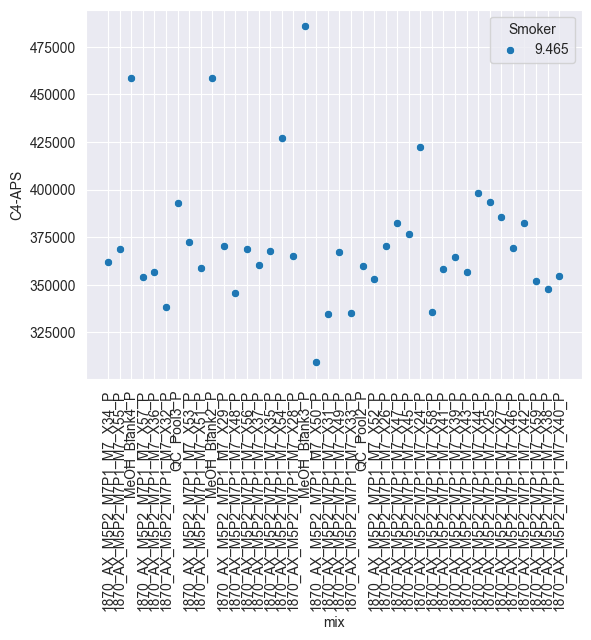

In [22]:
sns.scatterplot(x = raw_intensity_df['mix'], y = raw_intensity_df['C4-APS'])
plt.xticks(rotation=90)
plt.legend(title='Smoker', loc='upper right', labels=[np.round(raw_intensity_df['C4-APS'].describe()['std']/raw_intensity_df['C4-APS'].describe()['mean']*100, 3)])
plt.show()

In [26]:
# extract seed information
seed_file = io.readin_MSDIAL(os.path.join(peak_list_dir, seed_filename))
seed_rt, seed_intensity = find_istd(istd_info, test_file)

In [32]:
intensity_ratio = [x/y for (x, y) in zip(raw_intensity, seed_intensity)]
# everything should devide this factor

model_temp = RandomForestRegressor()
model_temp.fit(np.array(normalized_rt).reshape(-1,1), intensity_ratio)
predicted_ratio = model_temp.predict(np.array(normalized_rt).reshape(-1,1))
adjusted_intensity =[x/y for (x, y) in zip(raw_intensity, predicted_ratio)]

In [44]:
processing_folder = '/Users/fanzhou.kong/Dropbox (Brightseed)/Mac/Documents/GitHub/data_garage/brighseed/processing'

In [45]:
# normalized_row = []
# raw_row = []
# intensity_row = []
# good_filenames = []
# error_files = []
# rt normalization
for root, dirs, files in os.walk(peak_list_dir):
    for file in tqdm(files):
        # print(file)

        if file.endswith('.txt'):
            if file.split('.')[0][-1]==mode and file != seed_filename:
                test_file = io.readin_MSDIAL(os.path.join(peak_list_dir, file))
                raw_rt, raw_intensity = find_istd(istd_info, test_file)
                if len(raw_rt) == len(istd_info):
                    good_filenames.append(file.split('.')[0])
                    # break
                    # normalized_row_temp = [file.split('.')[0]]
                    # raw_row_temp = [file.split('.')[0]]
                    #         check if all istds can be found
                    rt_offset =  [seed - raw for (seed, raw) in zip(seed_rt, raw_rt)]
                    model_temp = RandomForestRegressor()
                    model_temp.fit(np.array(raw_rt).reshape(-1,1), rt_offset)
                    offset_pred = model_temp.predict(np.array(test_file['RT (min)']).reshape(-1,1))
                    normalized_rt = [off+raw for (off, raw) in zip(offset_pred, test_file['RT (min)'])]
                    test_file.insert(test_file.columns.get_loc('RT (min)'), 'RT_adjusted', normalized_rt)
                    test_file.to_csv(os.path.join(processing_folder, file.split('.')[0]+'.csv'), index = False)
                    # normalized_row_temp.extend(normalized_rt)
                    # raw_row_temp.extend(raw_rt)
                    # raw_row.append(raw_row_temp)
                    # normalized_row.append(normalized_row_temp)
                    # intensity_row.append(raw_intensity)
                    # break
            elif file == seed_filename:
                test_file = io.readin_MSDIAL(os.path.join(peak_list_dir, file))
                test_file.insert(test_file.columns.get_loc('RT (min)'), 'RT_adjusted', test_file['RT (min)'])
                test_file.to_csv(os.path.join(processing_folder, file.split('.')[0]+'.csv'), index = False)

100%|██████████| 44/44 [00:12<00:00,  3.49it/s]


In [56]:
seed_file= pd.read_csv(os.path.join(processing_folder, seed_filename.split('.')[0]+'.csv'))

In [62]:
test_file

,PeakID,Title,Scans,RT left(min),RT_adjusted,RT (min),RT right (min),Precursor m/z,Height,Area,...,m/z matched,MS/MS matched,RT similarity,Dot product,Reverse dot product,Fragment presence %,Total score,S/N,MS1 isotopes,MSMS spectrum
337,337,Unknown,172,0.377399,0.604495,0.604892,0.693270,100.0242,9120.386719,7.758573e+04,...,False,False,NaN,NaN,NaN,NaN,NaN,182.40770,100.02417:9221 100.07556:5920 100.11186:17820 ...,NaN
648,648,Unknown,242,0.114100,0.852010,0.852407,1.259764,100.1120,763502.875000,6.792386e+06,...,False,False,NaN,NaN,NaN,NaN,NaN,75.69155,100.02446:7080 100.07572:7661 100.10445:3609 1...,51.61277:7930 52.28661:7946 52.85661:7958 60.3...
7531,7531,Unknown,1602,5.421140,5.625474,5.625916,5.813559,100.2980,24908.191406,1.048282e+05,...,False,False,NaN,NaN,NaN,NaN,NaN,498.16380,100.29796:99633 101.02601:89066 101.38255:81333,NaN
12923,12923,Unknown,2416,8.086198,8.301009,8.294979,8.482091,100.3451,13769.366211,5.677265e+04,...,False,False,NaN,NaN,NaN,NaN,NaN,275.38730,100.11208:46388 100.34158:22211 100.34512:3286...,NaN
16353,16353,Unknown,2905,9.581866,9.819626,9.813596,9.978198,100.3586,115291.031250,4.930153e+05,...,False,False,NaN,NaN,NaN,NaN,NaN,2305.82100,100.35862:461164,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12415,12415,Unknown,2334,7.843028,8.042163,8.034576,8.224753,1461.7460,9739.442383,4.011764e+04,...,False,False,NaN,NaN,NaN,NaN,NaN,194.78880,1461.74622:38958,NaN
2871,2871,Unknown,938,3.149671,3.358703,3.359554,3.539162,1464.5330,2918.030518,1.244820e+04,...,False,False,NaN,NaN,NaN,NaN,NaN,58.36061,1464.53271:11672,NaN
12002,12002,Unknown,2286,7.681184,7.879151,7.877173,8.069983,1467.2110,50398.277344,2.124914e+05,...,False,False,NaN,NaN,NaN,NaN,NaN,1007.96600,1467.21143:201593 1468.22144:119456,NaN
12003,12003,Unknown,2286,7.681184,7.879151,7.877173,8.069983,1468.2210,29863.927734,1.259136e+05,...,False,False,NaN,NaN,NaN,NaN,NaN,597.27860,1468.22144:119456,NaN


In [60]:
seed_rt, seed_intensity = find_istd(istd_info, seed_file, return_adjusted_rt=True)
seeded = pd.DataFrame(list(zip(istd_info['[M+H]+'], seed_rt, seed_intensity )), columns=['pmz_protonated', 'RT', 'intensity'])

In [63]:
from feature_normalization.rt_normalization import find_seeded

In [65]:
rt_list, intensity_list = find_seeded(seeded, test_file)

In [119]:
file_list = []
raw_intensity_list = []
normalized_intensity_list = []
for root, dirs, files in os.walk(processing_folder):
    for file in tqdm(files):
        file_list.append(file.split('.')[0])
        if file.split('.')[0] != seed_filename.split('.')[0]:
            test_file = pd.read_csv(os.path.join(processing_folder, file))
            rt_list, intensity_list =find_seeded(seeded, test_file)
            intensity_ratio = [x/y for (x, y) in zip(intensity_list, seed_intensity)]


            # everything should devide this factor

            model_temp = RandomForestRegressor()
            model_temp.fit(np.array(rt_list).reshape(-1,1), intensity_ratio)
            predicted_ratio = model_temp.predict(np.array(rt_list).reshape(-1,1))
            adjusted_intensity_list =[x*y for (x, y) in zip(intensity_list, predicted_ratio)]
            intensity_list.insert(0, file.split('.')[0])
            raw_intensity_list.append(intensity_list)
            adjusted_intensity_list.insert(0, file.split('.')[0])

            normalized_intensity_list.append(adjusted_intensity_list)

            # pass
        # else:
        #     print('the problematic one is: ', str(file))


        # print(file)

100%|██████████| 41/41 [00:04<00:00,  8.50it/s]


[1.06492245,
 2.0571998,
 2.77280555,
 3.41055036,
 3.96920226,
 4.45315166,
 4.87419405,
 5.2805897900000005,
 5.65981872,
 6.0420818700000005,
 6.39917998,
 6.75019329,
 7.08946634,
 7.41887765,
 7.73435013,
 8.03148618,
 8.29829733]

In [120]:
column_names = istd_info['compound_name'].to_list()
column_names.insert(0, 'mix')
raw_df =pd.DataFrame(raw_intensity_list, columns=column_names)
normalized_df = pd.DataFrame(normalized_intensity_list, columns=column_names)

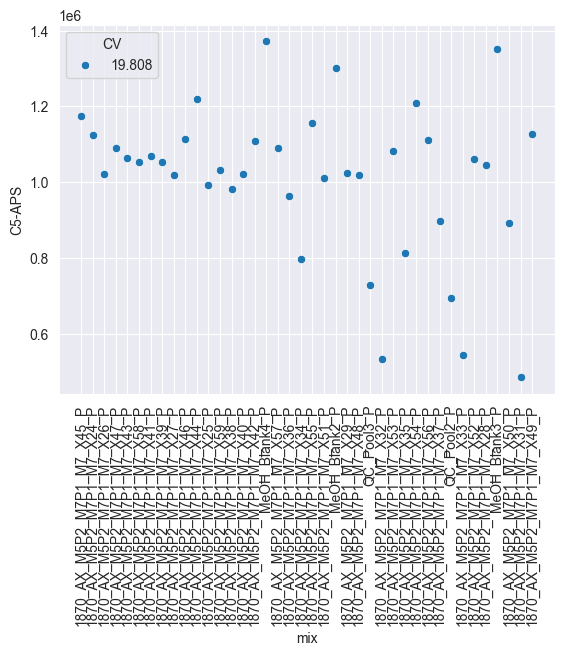

In [128]:
istd_name = 'C5-APS'
sns.scatterplot(x = raw_df['mix'], y = raw_df[istd_name])
plt.xticks(rotation=90)
plt.legend(title='CV', loc='upper left', labels=[np.round(raw_df[istd_name].describe()['std']/raw_df[istd_name].describe()['mean']*100, 3)])
plt.show()

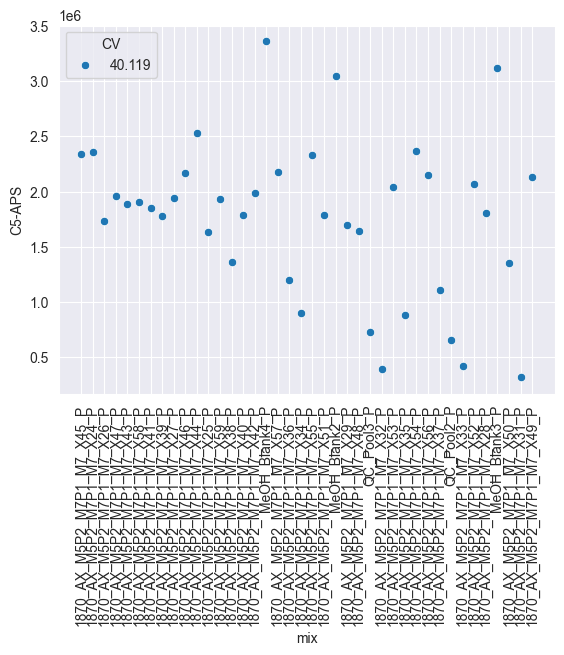

In [127]:
istd_name = 'C5-APS'
sns.scatterplot(x = normalized_df['mix'], y = normalized_df[istd_name])
plt.xticks(rotation=90)
plt.legend(title='CV', loc='upper left', labels=[np.round(normalized_df[istd_name].describe()['std']/normalized_df[istd_name].describe()['mean']*100, 3)])
plt.show()

In [126]:
istd_info['compound_name']

0      C4-APS
1      C5-APS
2      C6-APS
3      C7-APS
4      C8-APS
5      C9-APS
6     C10-APS
7     C11-APS
8     C12-APS
9     C13-APS
10    C14-APS
11    C15-APS
12    C16-APS
13    C17-APS
14    C18-APS
15    C19-APS
16    C20-APS
Name: compound_name, dtype: object